
# Exploratory Data Analysis (EDA) — SpaceX Launches

**Author:** Iliya Pezeshki
**Course:** IBM Data Science Professional Certificate — Capstone  

**Objective:** Explore distributions and relationships in the SpaceX launch dataset to understand factors associated with landing success.


## 1) Setup & Load Data

In [1]:

import requests, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 120)
plt.rcParams['figure.figsize'] = (8, 5)

DATA_CSV = Path('data/spacex_launches_clean.csv')

def load_or_fetch(path: Path) -> pd.DataFrame:
    if path.exists():
        print("Loading local CSV →", path.resolve())
        return pd.read_csv(path)
    # Fallback to SpaceX API v4 (self-contained)
    print("Local CSV not found. Fetching from SpaceX API v4 …")
    BASE = "https://api.spacexdata.com/v4"
    L = requests.get(f"{BASE}/launches", timeout=60).json()
    LP = requests.get(f"{BASE}/launchpads", timeout=60).json()
    R = requests.get(f"{BASE}/rockets", timeout=60).json()
    P = requests.get(f"{BASE}/payloads", timeout=60).json()
    LD = requests.get(f"{BASE}/landpads", timeout=60).json()
    lp_name = {x['id']: x.get('name') for x in LP}
    lp_full = {x['id']: x.get('full_name') for x in LP}
    rk_name = {x['id']: x.get('name') for x in R}
    py_mass = {x['id']: x.get('mass_kg') for x in P}
    py_orbit = {x['id']: x.get('orbit') for x in P}
    ld_name = {x['id']: x.get('name') for x in LD}
    def first_or_none(lst): return lst[0] if isinstance(lst, list) and len(lst)>0 else None
    rows = []
    for z in L:
        core0 = first_or_none(z.get('cores', [])) or {}
        payload_ids = z.get('payloads', [])
        masses = [py_mass.get(pid) for pid in payload_ids if pid in py_mass]
        orbits = [py_orbit.get(pid) for pid in payload_ids if pid in py_orbit]
        rows.append({
            'FlightNumber': z.get('flight_number'),
            'MissionName': z.get('name'),
            'DateUTC': z.get('date_utc'),
            'Rocket': rk_name.get(z.get('rocket')),
            'LaunchSite': lp_name.get(z.get('launchpad')) or lp_full.get(z.get('launchpad')),
            'PayloadMass': float(np.nansum(masses)) if masses else np.nan,
            'Orbit': orbits[0] if orbits else None,
            'LandingPad': ld_name.get(core0.get('landpad')) if core0.get('landpad') else None,
            'LandingSuccess': core0.get('landing_success'),
            'Class': 1 if core0.get('landing_success') is True else 0
        })
    return pd.DataFrame(rows).sort_values('FlightNumber').reset_index(drop=True)

df = load_or_fetch(DATA_CSV).copy()
df['DateUTC'] = pd.to_datetime(df['DateUTC'], errors='coerce', utc=True)
df['Year'] = df['DateUTC'].dt.year
df['PayloadMass'] = pd.to_numeric(df['PayloadMass'], errors='coerce')
df['FlightNumber'] = pd.to_numeric(df['FlightNumber'], errors='coerce')

# Focus on Falcon 9/Heavy
if 'Rocket' in df.columns:
    df = df[~df['Rocket'].fillna('').str.contains('Falcon 1', case=False, na=False)].copy()

print("Shape:", df.shape)
df.head()

Loading local CSV → C:\Users\USER\Downloads\data\spacex_launches_clean.csv
Shape: (200, 11)


,FlightNumber,MissionName,DateUTC,Rocket,LaunchSite,PayloadMass,Orbit,LandingType,LandingPad,Class,Year
5,6,Falcon 9 Test Flight,2010-06-04 18:45:00+00:00,Falcon 9,CCSFS SLC 40,0.0,LEO,NaN,NaN,0,2010
6,7,COTS 1,2010-12-08 15:43:00+00:00,Falcon 9,CCSFS SLC 40,0.0,LEO,NaN,NaN,0,2010
7,8,COTS 2,2012-05-22 07:44:00+00:00,Falcon 9,CCSFS SLC 40,525.0,LEO,NaN,NaN,0,2012
8,9,CRS-1,2012-10-08 00:35:00+00:00,Falcon 9,CCSFS SLC 40,800.0,ISS,NaN,NaN,0,2012
9,10,CRS-2,2013-03-01 19:10:00+00:00,Falcon 9,CCSFS SLC 40,677.0,ISS,NaN,NaN,0,2013


In [2]:

Path('figs').mkdir(exist_ok=True, parents=True)
print("Figures will be saved to ./figs")

Figures will be saved to ./figs



## 2) Launches by Site (bar chart)
**Why:** Compare launch volume across sites to understand operational distribution.


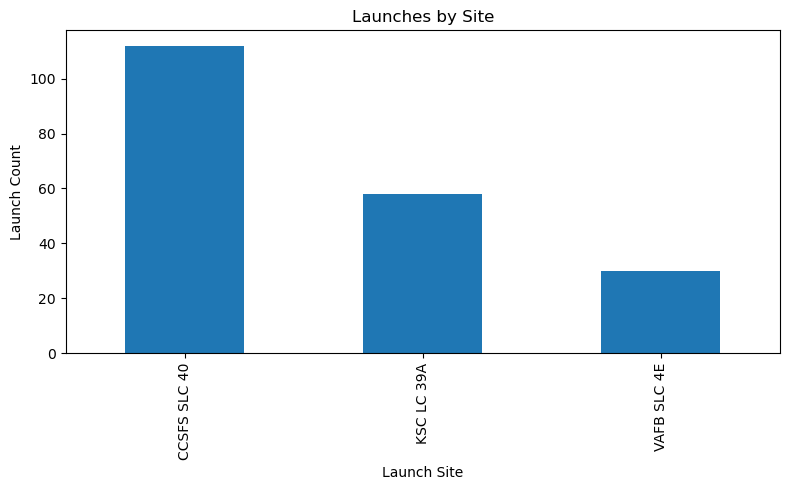

In [3]:

site_counts = df['LaunchSite'].value_counts().sort_values(ascending=False)
ax = site_counts.plot(kind='bar')
ax.set_xlabel('Launch Site'); ax.set_ylabel('Launch Count'); ax.set_title('Launches by Site')
plt.tight_layout(); plt.savefig('figs/launches_by_site.png'); plt.show()


## 3) Payload Mass Distribution (histogram)
**Why:** Understand the typical mass ranges and detect skew/outliers.


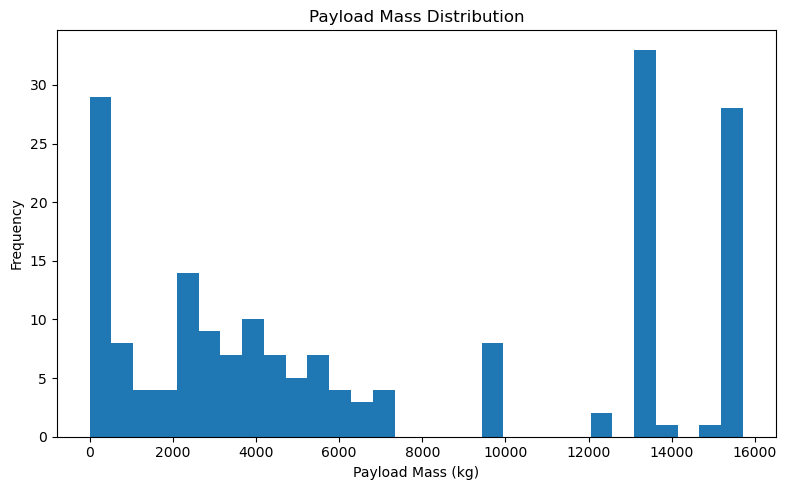

In [4]:

ax = df['PayloadMass'].dropna().plot(kind='hist', bins=30)
ax.set_xlabel('Payload Mass (kg)'); ax.set_title('Payload Mass Distribution')
plt.tight_layout(); plt.savefig('figs/payload_mass_hist.png'); plt.show()


## 4) Payload Mass by Orbit (boxplot)
**Why:** Compare mass distributions across orbit types to see systematic differences.


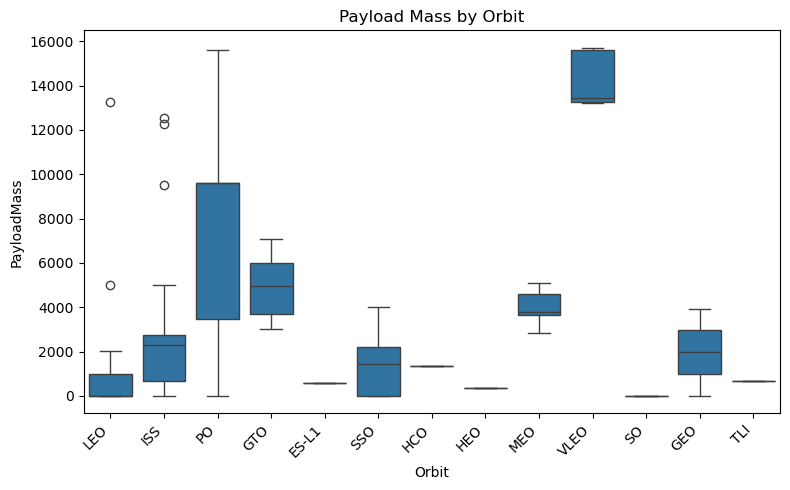

In [5]:

import seaborn as sns
plt.figure()
sns.boxplot(data=df, x='Orbit', y='PayloadMass')
plt.xticks(rotation=45, ha='right')
plt.title('Payload Mass by Orbit')
plt.tight_layout(); plt.savefig('figs/payload_by_orbit_box.png'); plt.show()


## 5) Success Rate by Launch Site (bar chart)
**Why:** Identify locations associated with higher landing success to inform site-level insights.


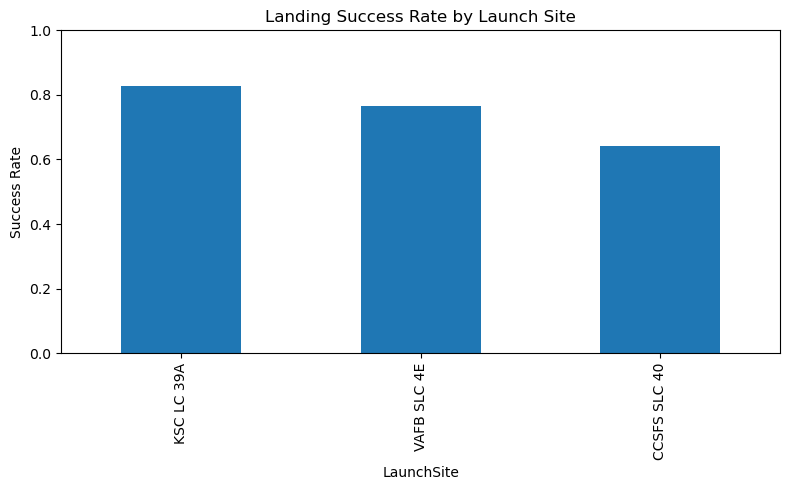

In [6]:

success_by_site = df.groupby('LaunchSite')['Class'].mean().sort_values(ascending=False)
ax = success_by_site.plot(kind='bar')
ax.set_ylim(0,1); ax.set_ylabel('Success Rate'); ax.set_title('Landing Success Rate by Launch Site')
plt.tight_layout(); plt.savefig('figs/success_rate_by_site.png'); plt.show()


## 6) Success Rate by Orbit (bar chart)
**Why:** Assess how mission orbit correlates with landing outcomes.


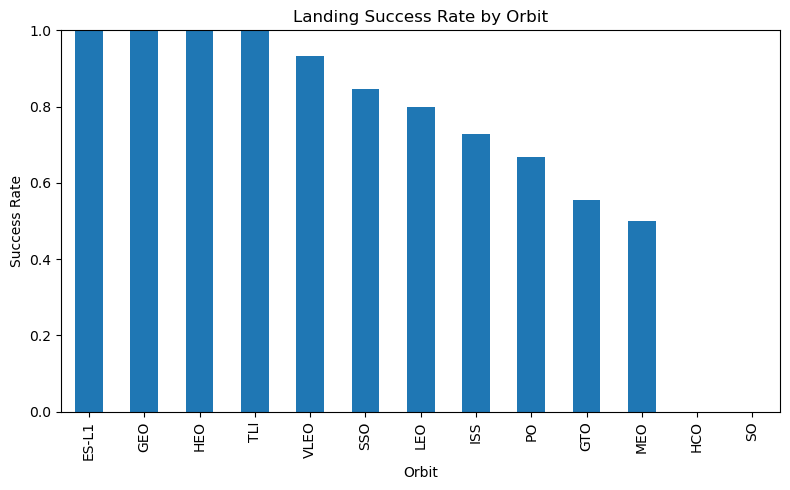

In [7]:

success_by_orbit = df.groupby('Orbit')['Class'].mean().sort_values(ascending=False)
ax = success_by_orbit.plot(kind='bar')
ax.set_ylim(0,1); ax.set_ylabel('Success Rate'); ax.set_title('Landing Success Rate by Orbit')
plt.tight_layout(); plt.savefig('figs/success_rate_by_orbit.png'); plt.show()


## 7) Flight Number vs Payload Mass (scatter, colored by outcome)
**Why:** Visualize whether mission sequence and payload relate to landing success.


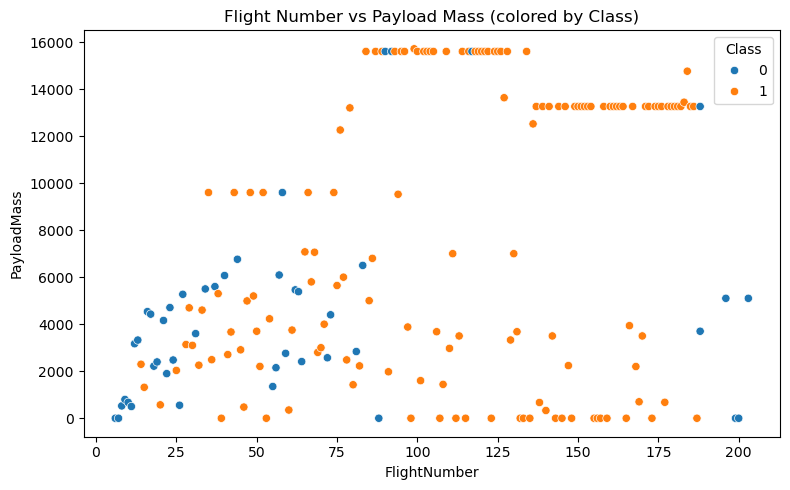

In [8]:

plt.figure()
sns.scatterplot(data=df, x='FlightNumber', y='PayloadMass', hue='Class')
plt.title('Flight Number vs Payload Mass (colored by Class)')
plt.tight_layout(); plt.savefig('figs/scatter_flight_vs_mass.png'); plt.show()


## 8) Trend: Yearly Landing Success Rate (line)
**Why:** Observe improvement trends over time.


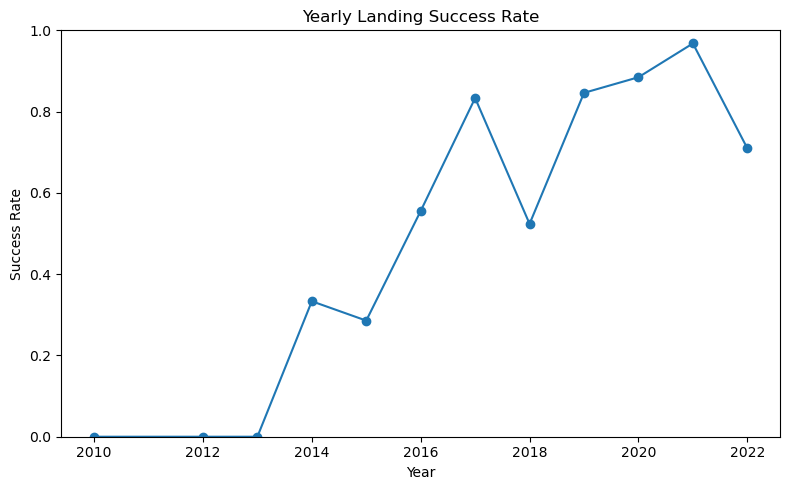

In [9]:

yearly = df.dropna(subset=['Year']).groupby('Year')['Class'].mean()
ax = yearly.plot(marker='o')
ax.set_ylim(0,1); ax.set_ylabel('Success Rate'); ax.set_title('Yearly Landing Success Rate')
plt.tight_layout(); plt.savefig('figs/yearly_success_rate.png'); plt.show()


## 9) Correlation Heatmap (numeric features)
**Why:** Quantify linear relationships among numeric variables.


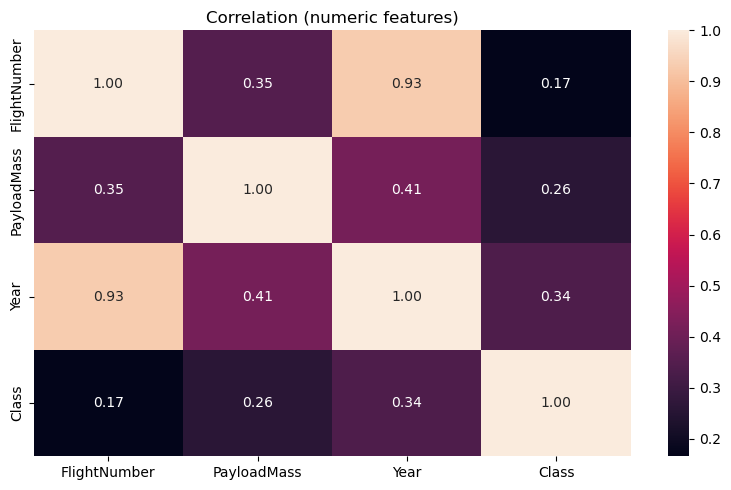

In [10]:

num_cols = ['FlightNumber','PayloadMass','Year','Class']
corr = df[num_cols].corr(numeric_only=True)
plt.figure()
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation (numeric features)')
plt.tight_layout(); plt.savefig('figs/corr_heatmap.png'); plt.show()